# Tutorial 2c - Monte Carlo Raytracing Methods

### July 2024

This tutorial shows one way in which Optiland can be used to run Monte Carlo simulations. Monte Carlo simulations are a computational technique used to model and analyze complex systems that involve randomness or uncertainty. They rely on repeated random sampling to estimate the behavior of a system and provide insights into the range of possible outcomes.

In a Monte Carlo simulation, a large number of random samples are generated based on the input parameters and their associated probability distributions. These samples are then used to simulate the system multiple times, allowing us to observe the distribution of outcomes and calculate various performance metrics.

Here, we will investigate how manufacturing variations of a simple singlet lens can impact performance. Note that this is a common tolerancing task.

Manufacturing variations to consider:

- Lens radius of curvature
- Lens index of refraction

Performance metrics to consider:

- RMS spot size
- RMS wavefront error

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from optiland import analysis, materials, optic, wavefront

We choose arbitrary ranges for the lens refractive index and radius:

- Refractive index: normal distribution, mean = 1.5, std=1e-3
- Radius of curvature: normal distribution, mean = 100, std=0.5

In total, we will simulate 1000 systems.

In [2]:
num_systems = 1000

# set random seed for repeatability
np.random.seed(42)

refractive_index = np.random.normal(loc=1.5, scale=1e-3, size=num_systems)
radius_of_curvature = np.random.normal(loc=100, scale=0.5, size=num_systems)

Let's define a helper class to easily generate random lenses. This is based on the simple singlet in optiland/samples/simple.py.

In [3]:
class SingletConfigurable(optic.Optic):
    """A configurable plano-convex singlet"""

    def __init__(self, radius_of_curvature, refractive_index):
        super().__init__()

        # define the material for the singlet
        ideal_material = materials.IdealMaterial(n=refractive_index, k=0)

        # add surfaces
        self.add_surface(index=0, radius=np.inf, thickness=np.inf)
        self.add_surface(
            index=1,
            thickness=5,
            radius=radius_of_curvature,
            is_stop=True,
            material=ideal_material,
        )
        self.add_surface(index=2, thickness=196.667)
        self.add_surface(index=3)

        # add aperture
        self.set_aperture(aperture_type="EPD", value=25.4)

        # add field
        self.set_field_type(field_type="angle")
        self.add_field(y=0)

        # add wavelength
        self.add_wavelength(value=0.55, is_primary=True)

        self.update_paraxial()

Let's view the first random system.

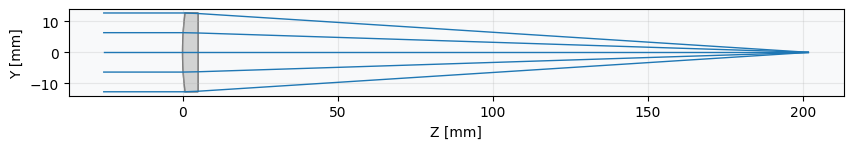

In [4]:
lens = SingletConfigurable(radius_of_curvature[0], refractive_index[0])
lens.draw(num_rays=5)

Now we will run the Monte Carlo simulation. In each of the 1000 iterations, we generate a random system, compute the rms spot radius and rms wavefront error, and record these values for later analysis.

This code uses functionalities from the analysis and wavefront modules, which will be discussed in more detail in future tutorials.

In [5]:
rms_spot_radius = []
rms_wavefront_error = []

for k in range(num_systems):
    # generate a random singlet
    lens = SingletConfigurable(radius_of_curvature[k], refractive_index[k])

    # get value of rms spot radius at field index = 0 and wavelength index = 0
    spot = analysis.SpotDiagram(lens)
    value = spot.rms_spot_radius()[0][0]
    rms_spot_radius.append(value)

    # get rms wavefront error
    opd = wavefront.OPD(lens, field=(0, 0), wavelength=0.55)
    rms_wavefront_error.append(opd.rms())

Let's plot the output distributions of our computed metrics:

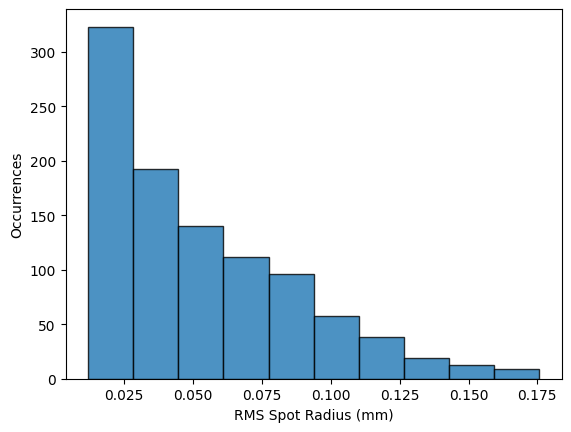

In [6]:
plt.hist(rms_spot_radius, color="C0", edgecolor="k", alpha=0.8)
plt.xlabel("RMS Spot Radius (mm)")
plt.ylabel("Occurrences")
plt.show()

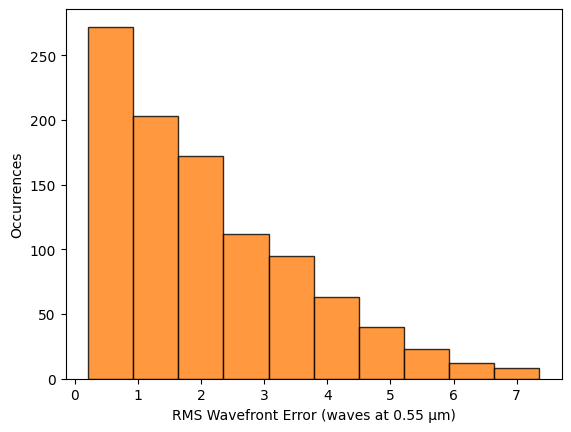

In [7]:
plt.hist(rms_wavefront_error, color="C1", edgecolor="k", alpha=0.8)
plt.xlabel("RMS Wavefront Error (waves at 0.55 µm)")
plt.ylabel("Occurrences")
plt.show()

Let's dive deeper into the relationships by looking at the correlation matrix

In [8]:
import seaborn as sns  # pip install seaborn

In [9]:
df = pd.DataFrame(
    dict(
        radius_of_curvature=radius_of_curvature,
        refractive_index=refractive_index,
        rms_spot_radius=rms_spot_radius,
        rms_wavefront_error=rms_wavefront_error,
    ),
)

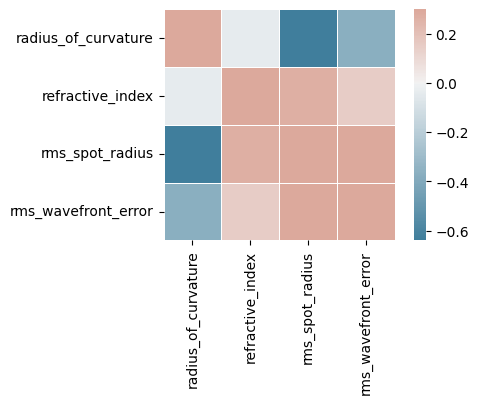

In [10]:
# This cell is based on https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Compute the correlation matrix
corr = df.corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 3))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=0.3, center=0, square=True, linewidths=0.5)

plt.show()

There are several relationships we can identify:

- The RMS spot size positively correlates to the RMS wavefront error, as expected.
- There is no correlation between refractive index and radius of curvature, as expected.
- There is a strong negatively correlation between the RMS spot radius and the radius of curvature.


Note that these relationships are not universally true, but are based on the Monte Carlo input distributions used, the system tested, etc. With different inputs, or a different optical system, the results would undoubtedly differ.